<a href="https://colab.research.google.com/github/chriswmann/customer-segmentation/blob/master/online_retail_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online Retail Data Analysis

## Introduction
This is an R jupyter notebook which explores the UCI Online Retail Data Set (Reference 1) and provides the beginnings of an investigation into customer segmentation.

NOTE: this is a work in progress.
 
## Data
The data set is a multivariate time series with the following features:

* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
* Description: Product (item) name. Nominal. 
* Quantity: The quantities of each product (item) per transaction. Numeric.	
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 
* UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
* Country: Country name. Nominal, the name of the country where each customer resides.

## Method

1. EDA: summary data, descriptive statistics and visualisations.
2. Cleaning and preparation.
3. Feature engineering.
4. RFM analysis.
5. Clustering.
6. Results.
7. Conclusions.

 
## References
1. http://archive.ics.uci.edu/ml/datasets/online+retail#

In [0]:
# Format plot area
options(repr.plot.width = 10, repr.plot.height = 6)

In [2]:
# Install/load relevant libraries
install.packages(c("corrr", "OneR"))
library(corrr)
library(lubridate)
library(OneR)
library(scales)
library(tidyverse)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘iterators’, ‘gridExtra’, ‘bitops’, ‘foreach’, ‘viridis’, ‘gtools’, ‘gdata’, ‘caTools’, ‘TSP’, ‘qap’, ‘gclus’, ‘dendextend’, ‘gplots’, ‘registry’, ‘seriation’, ‘ggrepel’

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ readr::col_factor()      masks scales::col_factor()
✖ lubridate::date()        masks base::date()
✖ purrr::discard()

In [0]:
# For convenience, I have hosted a CSV file version of the data
# on my GitHub page at this URL.
data_url <- 'https://raw.githubusercontent.com/chriswmann/datasets/master/online_retail/online_retail.csv'

In [4]:
# Load the data into a tibble using readr::read_csv
data <- read_csv(data_url)

Parsed with column specification:
cols(
  InvoiceNo = col_character(),
  StockCode = col_character(),
  Description = col_character(),
  Quantity = col_double(),
  InvoiceDate = col_character(),
  UnitPrice = col_double(),
  CustomerID = col_double(),
  Country = col_character()
)


In [0]:
set.seed(42)

# EDA

In [6]:
# The dimensions of the tibble show that we have 541909 samples with eight features per sample.
dim(data)

[1] 541909      8

In [7]:
# A quick look at the top of the data.
head(data)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850,United Kingdom
536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850,United Kingdom
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01/12/2010 08:26,7.65,17850,United Kingdom


In [8]:
# Check for missing values.
sapply(data, function(x) sum(is.na(x)))

InvoiceNo   StockCode Description    Quantity InvoiceDate   UnitPrice 
          0           0        1454           0           0           0 
 CustomerID     Country 
     135080           0

In [9]:
# Percentage of missing InvoiceDate
format(sum(is.na(data$Description)) / length(data$Description), digits = 3)

[1] "0.00268"

In [10]:
# Percentage of missing _CustomerID_
format(sum(is.na(data$CustomerID)) / length(data$CustomerID), digits = 3)

[1] "0.249"

So we have a few missing values, most notably CustomerID.

In [11]:
# How many unique values are there in each column?
rapply(data, function(x)length(unique(x)))

InvoiceNo   StockCode Description    Quantity InvoiceDate   UnitPrice 
      25900        4070        4212         722       23260        1630 
 CustomerID     Country 
       4373          38

Observations on missing values:
* We may be able to fill some *Description* values in by matching *StockCodes*.
* Filling some missing *CustomerID* values may be possible by matching *InvoiceNo*.

And a few observations on the number of unique values:
* There are approximately 2600 more invoices than dates.  This is perhaps to be expected, as multiple invoices could be raised within the same minute (which is the resolution of our InvoiceDate feature).  This may be expected to occur more often if there are clear peak times.  This is something we will investigate.
* There are more *Description* values than *StockCode* values, despite *Description* having 1454 missing values.  So we have items with the same *StockCode* but different *Description*.
* We can expect many items with the same *UnitPrice*.
* We can expect some customers to have many transactions.
* The dataset includes 38 countries.  One potential issue is how *InvoiceDate* has been recorded with respect to each country.  Unfortunately the [data description](http://archive.ics.uci.edu/ml/datasets/online+retail#) doesn't give us a firm answer.  As it states that invoice date is "the day and time when each transaction was generated", and all transactions are in GBP, we can reasonably assume that *InvoiceDate* is also consistent, probably GMT or UTC.

In [12]:
# Have a look at the structure of the data.
str(data)

Classes ‘spec_tbl_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	541909 obs. of  8 variables:
 $ InvoiceNo  : chr  "536365" "536365" "536365" "536365" ...
 $ StockCode  : chr  "85123A" "71053" "84406B" "84029G" ...
 $ Description: chr  "WHITE HANGING HEART T-LIGHT HOLDER" "WHITE METAL LANTERN" "CREAM CUPID HEARTS COAT HANGER" "KNITTED UNION FLAG HOT WATER BOTTLE" ...
 $ Quantity   : num  6 6 8 6 6 2 6 6 6 32 ...
 $ InvoiceDate: chr  "01/12/2010 08:26" "01/12/2010 08:26" "01/12/2010 08:26" "01/12/2010 08:26" ...
 $ UnitPrice  : num  2.55 3.39 2.75 3.39 3.39 7.65 4.25 1.85 1.85 1.69 ...
 $ CustomerID : num  17850 17850 17850 17850 17850 ...
 $ Country    : chr  "United Kingdom" "United Kingdom" "United Kingdom" "United Kingdom" ...
 - attr(*, "spec")=
  .. cols(
  ..   InvoiceNo = col_character(),
  ..   StockCode = col_character(),
  ..   Description = col_character(),
  ..   Quantity = col_double(),
  ..   InvoiceDate = col_character(),
  ..   UnitPrice = col_double(),
  ..   CustomerID = col_

Looking at the structure of the data we can see that the invoice date is currently in character rather than date type.  So that we can make the most use of this data we'll convert InvoiceDate to datetime.

In [0]:
data$InvoiceDate <- as.POSIXct(data$InvoiceDate,
                              format="%d/%m/%Y %H:%M")

In [14]:
# Double check the datetime conversion did not introduce any NAs.
sapply(data, function(x) sum(is.na(x)))

InvoiceNo   StockCode Description    Quantity InvoiceDate   UnitPrice 
          0           0        1454           0           0           0 
 CustomerID     Country 
     135080           0

In [15]:
head(data)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom


In [16]:
tail(data)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680,France
581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France
581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France


In [17]:
summary(data)

  InvoiceNo          StockCode         Description           Quantity        
 Length:541909      Length:541909      Length:541909      Min.   :-80995.00  
 Class :character   Class :character   Class :character   1st Qu.:     1.00  
 Mode  :character   Mode  :character   Mode  :character   Median :     3.00  
                                                          Mean   :     9.55  
                                                          3rd Qu.:    10.00  
                                                          Max.   : 80995.00  
                                                                             
  InvoiceDate                    UnitPrice           CustomerID    
 Min.   :2010-12-01 08:26:00   Min.   :-11062.06   Min.   :12346   
 1st Qu.:2011-03-28 11:34:00   1st Qu.:     1.25   1st Qu.:13953   
 Median :2011-07-19 17:17:00   Median :     2.08   Median :15152   
 Mean   :2011-07-04 13:34:57   Mean   :     4.61   Mean   :15288   
 3rd Qu.:2011-10-19 11:27:00   3rd Q

Observations on the summary statistics:
1. The minimum *Quantity* is negative.  
2. Although many of the the customers are wholesalers, the fact that the maximum *Quantity* has the same absolute value as the minimum quantity suggests this value is suspicious.
2. The date range matches that in the [data description](http://archive.ics.uci.edu/ml/datasets/online+retail#).
3. The minimum *UnitPrice* is negative.
4. The maximum *UnitPrice* is somewhat suspicious given that the 3rd quartile is £4.13.
5. *UnitPrice* and *Quantity* are heavily right-skewed.

In [18]:
# Have a look at prices above £5,000
data[data$UnitPrice > 5000, ]

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NA,United Kingdom
537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NA,United Kingdom
C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,NA,United Kingdom
C537647,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:41:00,5519.25,NA,United Kingdom
C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NA,United Kingdom
C537652,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:51:00,6706.71,NA,United Kingdom
C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,NA,United Kingdom
C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,NA,United Kingdom
C544587,AMAZONFEE,AMAZON FEE,-1,2011-02-21 15:07:00,5575.28,NA,United Kingdom


Interestingly, as noted in the data description, most of these invoice numbers begin with 'C', and so are cancellations.

Additionally, all but two of these transactions have negative quantities, which suggests that the uses negative quantities for cancellations/refunds.  Producing a customer segment based on number of cancellations may be of use.

In this particular set of samples all of the transactions are from the UK.  The data description states that it is from a UK company and so we may expect the majority of transactions to have occured there (perhaps due to a better-established brand in that region.)

There seems to be a discrepancy between the high prices and low quantities.  Some duplicate invoice numbers can be seen above but perhaps the larger values arise because an order with multiple items is sometimes cancelled under a single transaction.  Let's investigate.

In [0]:
# Get a vector of cancellation invoice numbers
cancellation_invoices <- data$InvoiceNo[grep('^C[0-9]*', data$InvoiceNo)]

In [0]:
# Remove the "C" from the cancellation invoice numbers
cancellation_invoices <- substring(cancellation_invoices, 2)

In [21]:
# Check if there are any overlaps between purchase and cancellation invoice numbers
intersect(cancellation_invoices, data$InvoiceNo)

character(0)

In [22]:
paste(max(substring(data$InvoiceNo, 2)), min(cancellation_invoices))

[1] "81587 536379"

Without further information it will not be simple to match purchase transactions with cancellations.  Instead we will see if we can identify customers with both purchases and cancellations.

In [23]:
data %>%
    group_by(CustomerID) %>%
    filter((Quantity < 0 & Quantity > 0) | (UnitPrice < 0 & UnitPrice > 0))

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>


Doesn't look like that's going to work for us either.  For now we will discard rows with values less than or equal to zero for *Quantity* and/or *UnitPrice*.

In [0]:
purchases <- data %>%
                filter(Quantity > 0, UnitPrice > 0)

In [25]:
# Check the cancellations and adjustments have been removed by filtering on invoice numbers starting with "A" or "C"
purchases[grep('^A|C[0-9]*', purchases$InvoiceNo), ]

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NA,United Kingdom


This confirms that most negative quantities and/or prices are for cancellations.  For now we will drop this remaining sample but clearly there is an important customer segment here and investigation may reveal ways to reduce order cancellations.

In [0]:
# Drop this sample too
purchases <- purchases[grep('^[0-9]+', purchases$InvoiceNo), ]

In [0]:
# To work within Colab's memory constrains, we will delete data and cancellation_invoices
rm(data, cancellation_invoices)

In [28]:
head(purchases)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom


Let's look at the most popular items by country and by customer.

In [29]:
na.omit(purchases) %>%
    group_by(Country) %>%
    arrange(Quantity)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
536381,71270,PHOTO CLIP LINE,1,2010-12-01 09:41:00,1.25,15311,United Kingdom
536381,22262,FELT EGG COSY CHICKEN,1,2010-12-01 09:41:00,0.85,15311,United Kingdom
536381,22637,PIGGY BANK RETROSPOT,1,2010-12-01 09:41:00,2.55,15311,United Kingdom
536381,21166,COOK WITH WINE METAL SIGN,1,2010-12-01 09:41:00,1.95,15311,United Kingdom
536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,1,2010-12-01 09:41:00,2.95,15311,United Kingdom
536381,37444C,PINK BREAKFAST CUP AND SAUCER,1,2010-12-01 09:41:00,2.95,15311,United Kingdom
536381,22083,PAPER CHAIN KIT RETROSPOT,1,2010-12-01 09:41:00,2.95,15311,United Kingdom
536381,22261,FELT EGG COSY WHITE RABBIT,1,2010-12-01 09:41:00,0.85,15311,United Kingdom
536381,84832,ZINC WILLIE WINKIE CANDLE STICK,1,2010-12-01 09:41:00,0.85,15311,United Kingdom


In [30]:
na.omit(purchases) %>%
    group_by(CustomerID) %>%
    arrange(Quantity)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
536381,71270,PHOTO CLIP LINE,1,2010-12-01 09:41:00,1.25,15311,United Kingdom
536381,22262,FELT EGG COSY CHICKEN,1,2010-12-01 09:41:00,0.85,15311,United Kingdom
536381,22637,PIGGY BANK RETROSPOT,1,2010-12-01 09:41:00,2.55,15311,United Kingdom
536381,21166,COOK WITH WINE METAL SIGN,1,2010-12-01 09:41:00,1.95,15311,United Kingdom
536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,1,2010-12-01 09:41:00,2.95,15311,United Kingdom
536381,37444C,PINK BREAKFAST CUP AND SAUCER,1,2010-12-01 09:41:00,2.95,15311,United Kingdom
536381,22083,PAPER CHAIN KIT RETROSPOT,1,2010-12-01 09:41:00,2.95,15311,United Kingdom
536381,22261,FELT EGG COSY WHITE RABBIT,1,2010-12-01 09:41:00,0.85,15311,United Kingdom
536381,84832,ZINC WILLIE WINKIE CANDLE STICK,1,2010-12-01 09:41:00,0.85,15311,United Kingdom


We can see that there is a lot of similarity between the top items, suggesting that a product's popularity is generally not strongly affected by the region in which it is for sale.

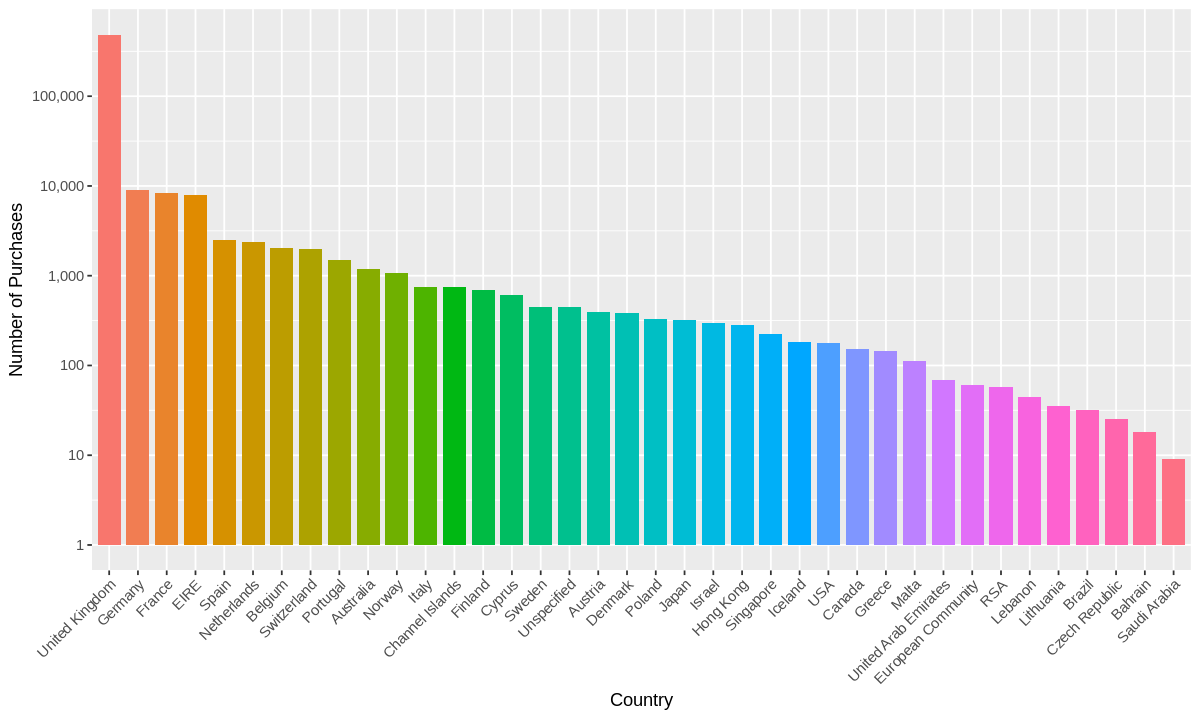

In [31]:
ggplot(purchases, aes(x = fct_infreq(Country), fill = fct_infreq(Country))) +
       geom_bar(width = 0.8, show.legend = F) + 
       scale_y_log10(labels = comma,
                     breaks = trans_breaks("log10", function(x) 10^x)) +
       xlab('Country') +
       ylab('Number of Purchases') +
       theme(axis.text.x = element_text(angle = 45, hjust = 1))

We can see a few things from this plot:
1. There are over 50 times more purchases in the UK than the next highest country, Germany.
2. There are several hundred purchases with *Country* given as "Unspecified" and dozens listed as "European Comminity".
3. There does not appear to be a correlation between geographical proximity to the UK and the number of purchases.

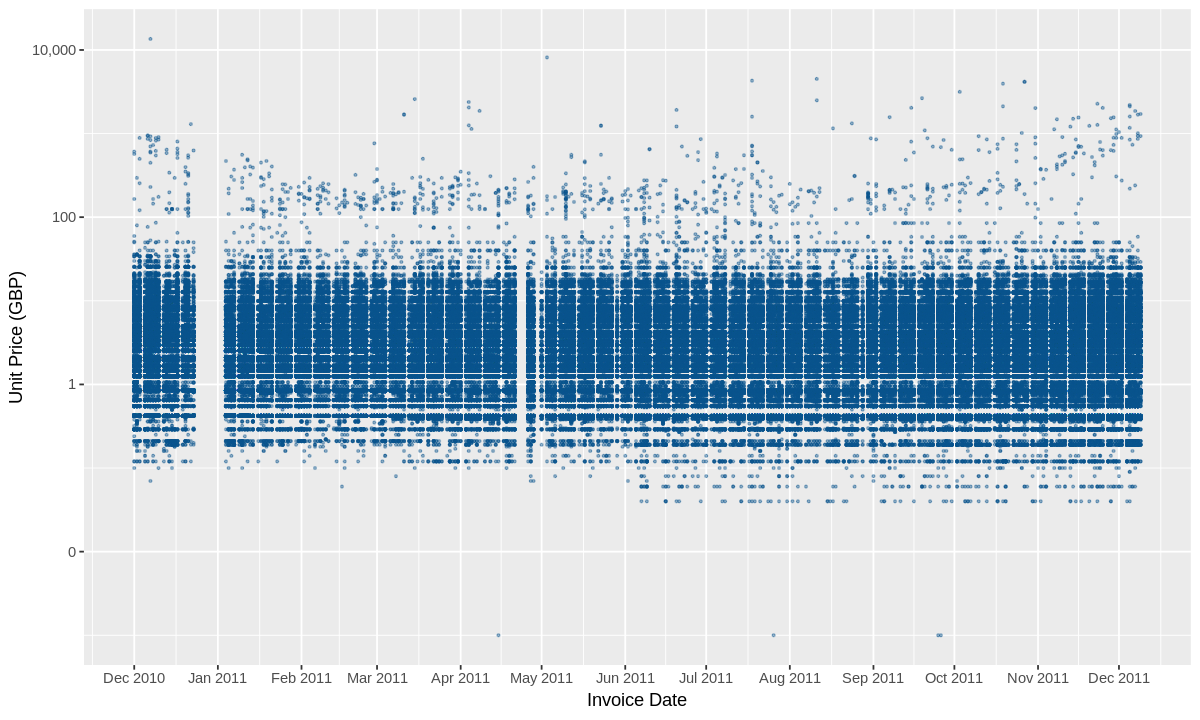

In [32]:
ggplot(purchases, aes(x = as.Date(InvoiceDate), y = UnitPrice)) +
       geom_point(colour = "#08538c", size = 0.5, alpha = 0.4) +
       scale_x_date(breaks = pretty_breaks(10)) +
       scale_y_log10(labels = comma,
                     breaks = trans_breaks("log10",
                                           function(x) 10^x)) +
        xlab("Invoice Date") +
        ylab("Unit Price (GBP)")

From this plot we can see:
1. The vast majority of products have a *UnitPrice* of less than £100 but there are some very high prices.
2. There does not appear to be a discernible trend over time, with the possible exception of increasing variance in *UnitPrice*.  This could be due to a number of factors, such as broadening stock range or activity in new markets over time.
3. There is data missing at the end of December 2010 to early January 2011 and again at the end of April 2011.
4. There is less/missing data at regular intervals, which appear to be approximately weekly.

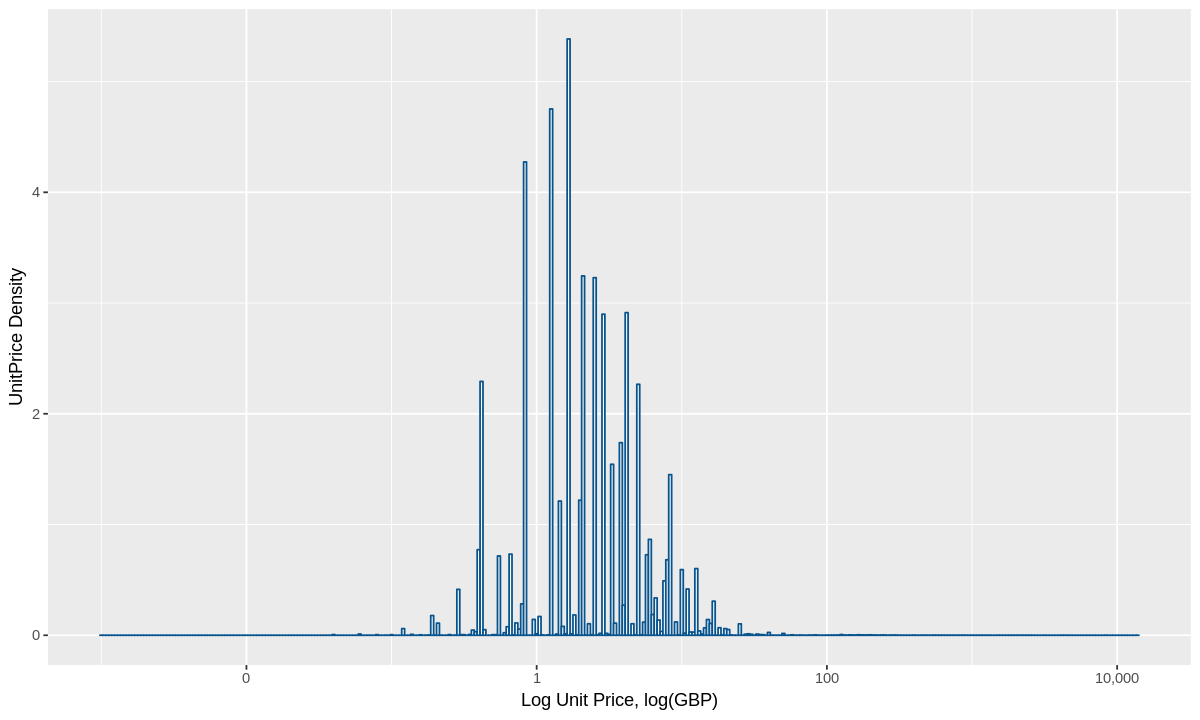

In [33]:
# Plot distribution of UnitPrice
ggplot(purchases, aes(x = UnitPrice)) + 
    geom_histogram(aes(y = ..density..),
                   binwidth = 0.02,
                   colour="#08538c", fill="white") +
    scale_x_log10(labels = comma,
                  breaks = trans_breaks("log10",
                                           function(x) 10^x)) +
    xlab("Log Unit Price, log(GBP)") +
    ylab("UnitPrice Density")
    

From this plot we can see:
1. The distribution of *UnitPrice* is heavily right-skewed as seen earlier.
2. Some unit prices are much less common than others.  Speculatively, this could be due to the use of odd pricing (prices ending in '.99') as is [commonly found in retail](http://marketing-bulletin.massey.ac.nz/V8/MB_V8_N1_Holdershaw.pdf).

In [0]:
monthly_price_variance <- purchases %>%
                          mutate(date = format(InvoiceDate, "%Y-%m")) %>%
                          group_by(date) %>%
                          summarise(sd_UnitPrice = sd(UnitPrice))

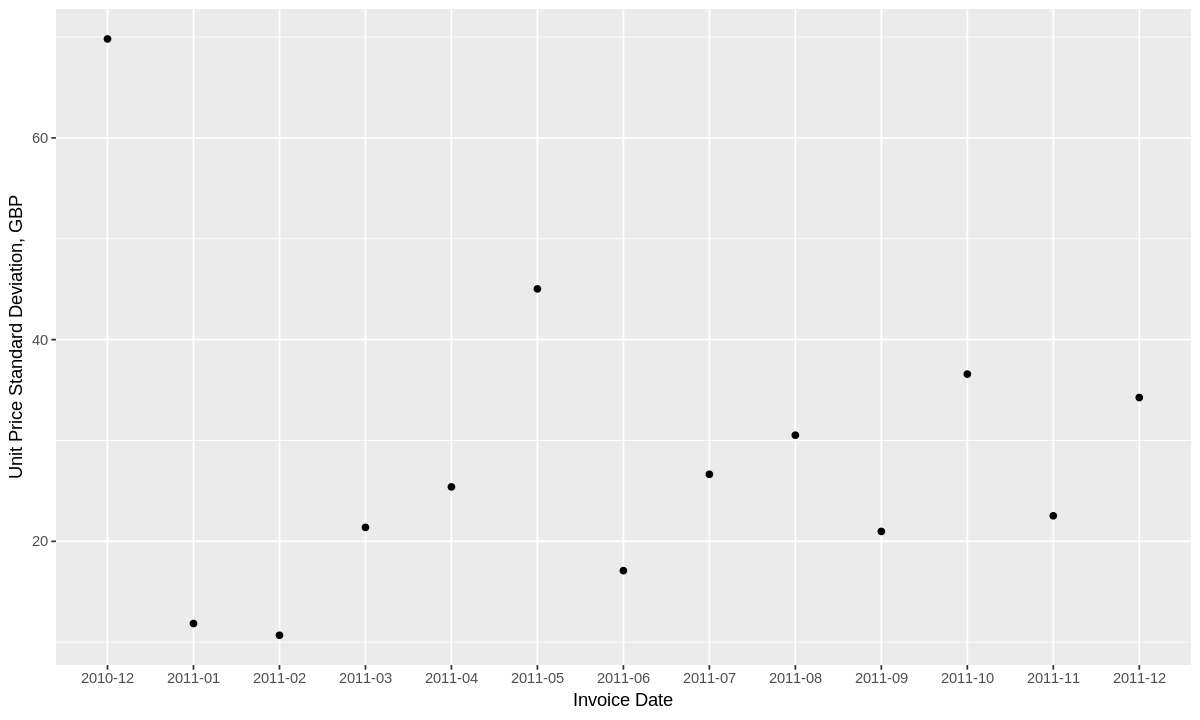

In [35]:
ggplot(monthly_price_variance, aes(x = date, y = sd_UnitPrice)) +
    geom_point() +
    xlab("Invoice Date") +
    ylab("Unit Price Standard Deviation, GBP")

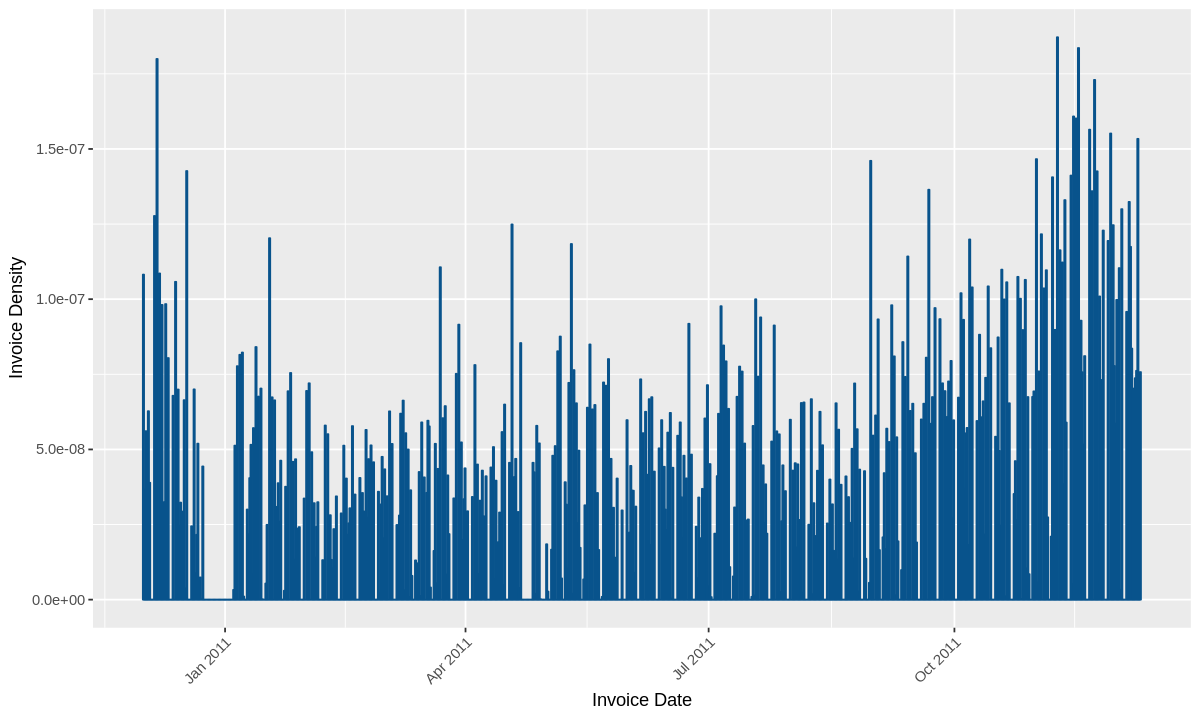

In [36]:
# Plot distribution of InvoiceDate
ggplot(purchases, aes(x = InvoiceDate)) + 
    geom_histogram(aes(y = ..density..),
                   binwidth = 40000,
                   colour="#08538c", fill="white") +
    xlab("Invoice Date") +
    ylab("Invoice Density") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))   

Let's see how the daily number of transactions are distributed with the day of the week.

In [37]:
transactions_per_day_of_week <- purchases %>%
                                count(Day = weekdays(floor_date(InvoiceDate,
                                                                "day")),
                                      name = "Count") %>%
                                arrange(Count)
transactions_per_day_of_week$Proportion <- transactions_per_day_of_week$Count / sum(transactions_per_day_of_week$Count)
transactions_per_day_of_week

Day,Count,Proportion
<chr>,<int>,<dbl>
Sunday,63905,0.1205520
Friday,80280,0.1514423
Wednesday,92315,0.1741454
Monday,93136,0.1756942
Tuesday,99460,0.1876239
Thursday,101007,0.1905422


Interestingly we can see:
1. There are no transactions recorded on Saturdays!  This seems very odd, given that there are transactions for every other day of the week.  Depending on whether transaction records are actually missing, or whether they are assigned to another day (which seems less plausible, especially since the next day, Sunday, has the next fewest transactions) this could have an impact on recency scores, especially for customers with low numbers of total transactions.  This should be investigated.
2. There tends to be fewer transactions on Friday and Sunday and Thursday has the highest proportion of transactions.

To assist in the analysis and understand of cutomer spending, let's create a *InvoiceTotal* variable which is the total value in GBP for a given invoice number.

In [0]:
purchases$InvoiceTotal = purchases$Quantity * purchases$UnitPrice

In [0]:
customer_purchases <- purchases %>%
                      group_by(CustomerID) %>%
                      summarise(Count = n(),
                                TotalSpend = sum(InvoiceTotal)) %>%
                      arrange(desc(TotalSpend))

In [40]:
head(customer_purchases)

CustomerID,Count,TotalSpend
<dbl>,<int>,<dbl>
NA,132219,1744214.6
14646,2076,280206.0
18102,431,259657.3
17450,337,194550.8
16446,3,168472.5
14911,5675,143825.1


In [41]:
tail(customer_purchases)

CustomerID,Count,TotalSpend
<dbl>,<int>,<dbl>
17763,1,15.00
16878,3,13.30
17956,1,12.75
16454,2,6.90
14792,2,6.20
16738,1,3.75


*customer_purchases* is beginning to give us the Monetary analysis part of RFM.  Immediately we can see the significant issue cause by the large number of *NA* values in *CustomerID*.

Let's see if we can identify missing *CustomerID*  values from *InvoiceNo*.  This assumes each *InvoiceNo* has a single, unique customer, which is a reasonable assumption.

In [0]:
purchases <- purchases %>%
             group_by(InvoiceNo) %>%
             fill(CustomerID, .direction = "down") %>%
             ungroup()

In [43]:
head(purchases)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>,<dbl>
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30


In [44]:
# Check for missing values.
sapply(purchases, function(x) sum(is.na(x)))

InvoiceNo    StockCode  Description     Quantity  InvoiceDate    UnitPrice 
           0            0            0            0            0            0 
  CustomerID      Country InvoiceTotal 
      132219            0            0

Previously there were 135,080 missing values for *CustomerID*, so we have been able to fill 2,861 records using *InvoiceNo* matching.  There may be other ways to fill missing customer IDs, especially if we had access to the mechanisms by which the data was collected or other data sources from the same company.  For now we will simply drop rows with missing *CustomerID* and assess the potential impact by comparing the samples with a *CustomerID* with those samples without one.

(We can also see that the missing descriptions have been removed, which occurred when we removed negative quantities and unit prices.)

In [0]:
with_customerID <- subset(purchases, !is.na(purchases$CustomerID))
without_customerID <- subset(purchases, is.na(purchases$CustomerID))

#### Compare invoice totals

As the sample sizes are different and the distributions are skewed, we'll bootstrap each sample and compare the sampling distribution of the sample means using a t-test.


In [0]:
with_ID_total <- with_customerID$InvoiceTotal

In [0]:
without_ID_total <- without_customerID$InvoiceTotal

In [48]:
with_ID_mean <- mean(with_ID_total)
without_ID_mean <- mean(without_ID_total)
c(with_ID_mean, without_ID_mean)

[1] 22.39700 13.19186

In [49]:
abs_diff_mean <- abs(with_ID_mean - without_ID_mean)
abs_diff_mean

[1] 9.20514

In [0]:
# Number of samples
n <- min(c(length(with_ID_total), length(without_ID_total)))
# Number of replications
R <- 10000

In [51]:
with_ID_bootstrap <- replicate(R, mean(sample(with_ID_total, size = n, replace = T)))
head(with_ID_bootstrap)

[1] 22.46026 22.28594 23.20319 21.55274 22.06979 21.56541

In [52]:
without_ID_bootstrap <- replicate(R, mean(sample(without_ID_total, size = n, replace = T)))
head(without_ID_bootstrap)

[1] 13.27463 13.34951 13.35375 13.54312 13.16493 13.09314

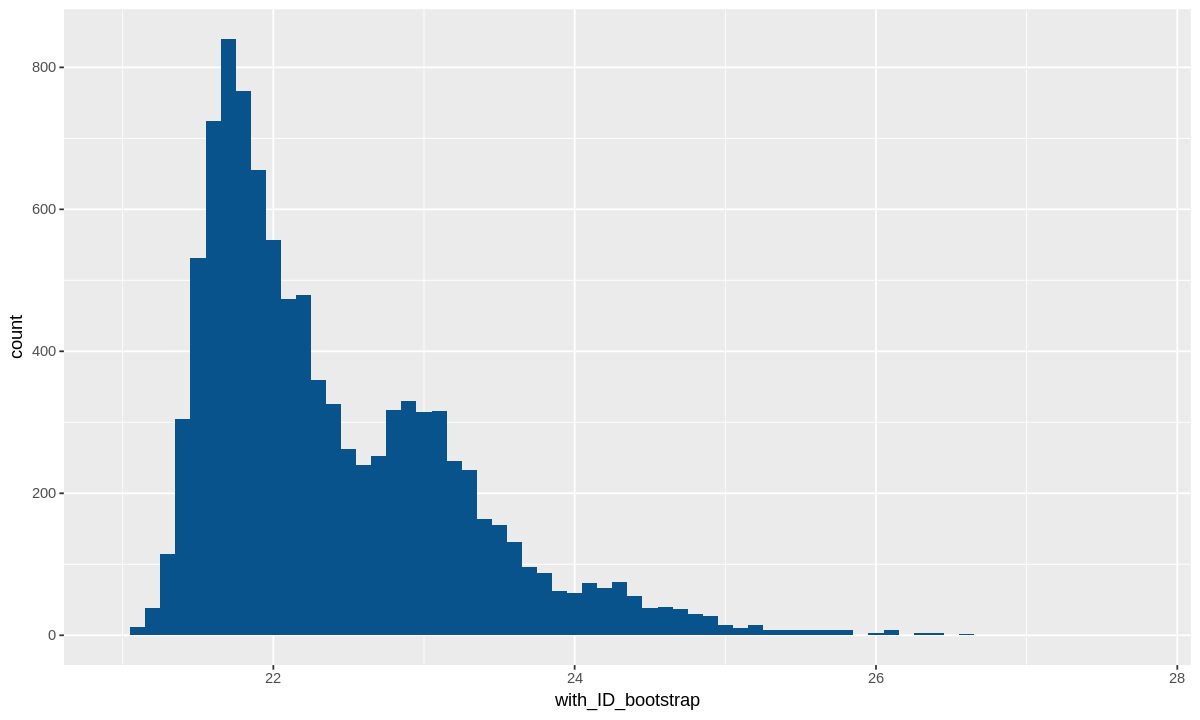

In [53]:
ggplot(as.data.frame(with_ID_bootstrap), aes(x = with_ID_bootstrap)) +
    geom_histogram(binwidth = 0.1, fill = "#08538c")

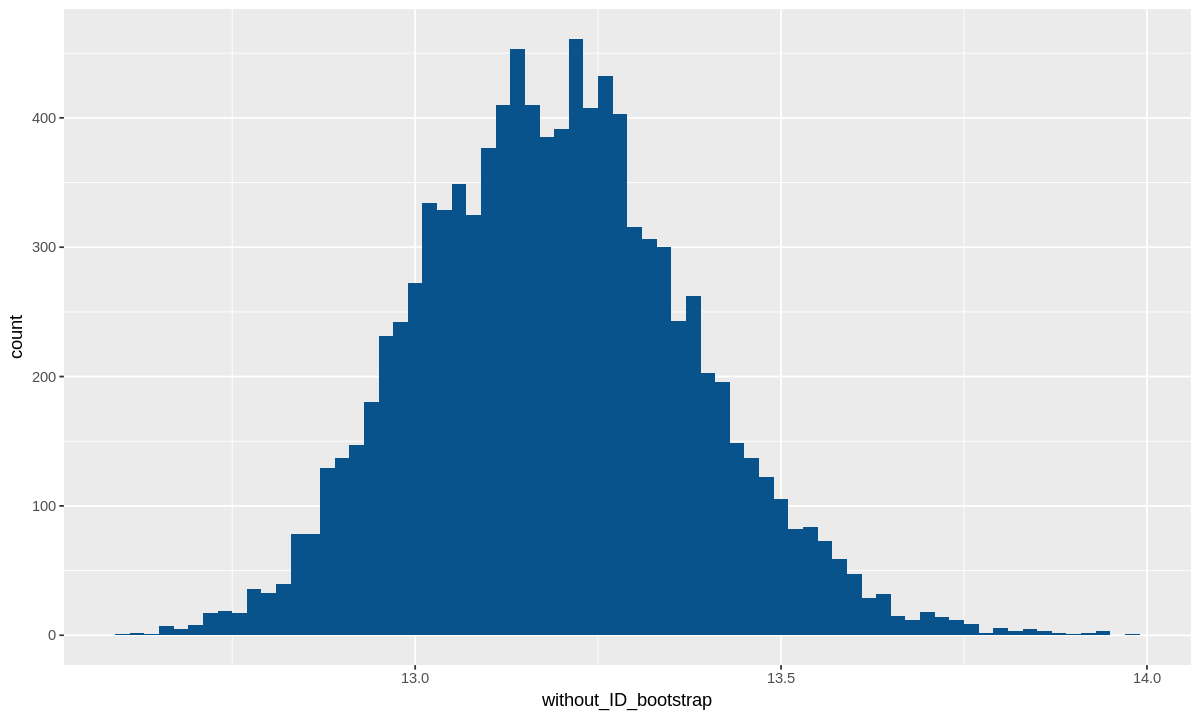

In [54]:
ggplot(as.data.frame(without_ID_bootstrap), aes(x = without_ID_bootstrap)) +
    geom_histogram(binwidth = 0.02, fill = "#08538c")

We can see that the sampling distribution for purchases with a *CustomerID* is still not normally distributed, although it is closer than the data distribution.  The sampling distribution for purchases without a customer ID looks normally distributed, a conclustion that could be tested with a Shapiro-Wilk test.  As the t-test is robust against non-normality, we will proceed.  We could rely on the CLT to obtain more normallty in the sampling distributions but the run time on Google Colab is already quite long.

In [55]:
# Check the variances of each sampling distribution
c(var(with_ID_bootstrap), var(without_ID_bootstrap))

[1] 0.72969869 0.03535054

In [56]:
t.test(with_ID_bootstrap, without_ID_bootstrap,
       equal.var = F)


	Welch Two Sample t-test

data:  with_ID_bootstrap and without_ID_bootstrap
t = 1052.8, df = 10966, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 9.190964 9.225254
sample estimates:
mean of x mean of y 
 22.39988  13.19177 


With such a large t-statistic and small p-value, and a meaningful effect size, we can see that there is a significant difference in *TotalPrice* between the sample sets with and without *CustomerID*.  This should therefore be investigated and customer IDs obtained where possible.

In [0]:
# Remove samples without customer IDs
purchases <- subset(purchases, !is.na(purchases$CustomerID))

Warning message:
“Removed 1 rows containing missing values (position_stack).”

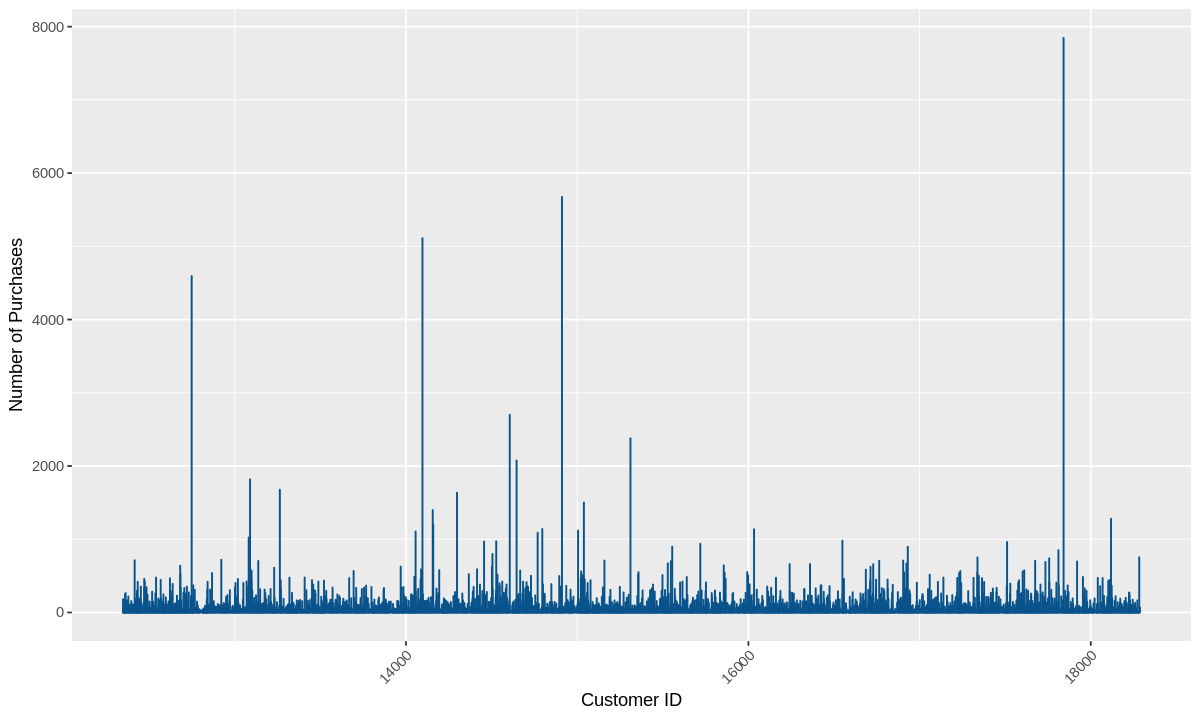

In [58]:
# Plot distribution of purchases per customer
ggplot(customer_purchases, aes(x = CustomerID, y = Count)) + 
    geom_col(colour="#08538c", fill="white") +
    xlab("Customer ID") +
    ylab("Number of Purchases") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))   


We can see that there are many customers with near-zero numbers of purchases.  Ideally, the lack of transaction records for Saturdays should therefore be investigated.

## Feature Engineering

In [59]:
# Remind ourselves what features we currently have
colnames(purchases)

[1] "InvoiceNo"    "StockCode"    "Description"  "Quantity"     "InvoiceDate" 
[6] "UnitPrice"    "CustomerID"   "Country"      "InvoiceTotal"

Firstly, we'll reduce the resolution of *InvoiceDate* to daily, which is a reasonable unit to use for analysis of data for a period of over one year.

In [0]:
purchases <- purchases %>%
             mutate(InvoiceDate = floor_date(InvoiceDate, "day"))

### Add Recency

In [0]:
purchases$Recency <- as.integer(max(purchases$InvoiceDate) - purchases$InvoiceDate)

### Add frequency features

In [62]:
purchases <- purchases %>%
             group_by(CustomerID) %>%
             mutate(Frequency = n())
purchases <- purchases[, !(names(purchases) == 'tmp')]

purchases <- purchases %>%
             group_by(CustomerID, tmp = floor_date(InvoiceDate, "month")) %>%
             mutate(FrequencyMonthly = n())
purchases <- purchases[, !(names(purchases) == 'tmp')]

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

### Add Monetary Features

In [0]:
purchases <- purchases %>%
             group_by(CustomerID) %>%
             mutate(Monetary = sum(InvoiceTotal)) %>%
             ungroup()
             
purchases <- purchases %>%
             group_by(CustomerID, tmp = floor_date(InvoiceDate, "month")) %>%
             mutate(MonetaryMonthly = sum(InvoiceTotal)) %>%
             ungroup()
purchases <- purchases[, !(names(purchases) == 'tmp')]

In [64]:
head(purchases)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal,Recency,Frequency,FrequencyMonthly,Monetary,MonetaryMonthly
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30,32227200,297,297,5391.21,5391.21
536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34,32227200,297,297,5391.21,5391.21
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00,32227200,297,297,5391.21,5391.21
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34,32227200,297,297,5391.21,5391.21
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34,32227200,297,297,5391.21,5391.21
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01,7.65,17850,United Kingdom,15.30,32227200,297,297,5391.21,5391.21


The binning and scoring process has caused Colab to restart due to excessing memory usage.  We will therefore create a dedicated RFM dataset and then save *purchases* to disk and remove it from the workspace.

In [0]:
rfm_data <- unique(purchases[, c('CustomerID', 'Recency', 'Frequency', 'Monetary')])

In [66]:
head(rfm_data)

CustomerID,Recency,Frequency,Monetary
<dbl>,<int>,<int>,<dbl>
17850,32227200,297,5391.21
13047,32227200,172,3237.54
12583,32227200,247,7281.38
13748,32227200,28,948.25
15100,32227200,3,876.00
15291,32227200,103,4668.30


In [67]:
tail(rfm_data)

CustomerID,Recency,Frequency,Monetary
<dbl>,<int>,<int>,<dbl>
17581,0,440,11045.04
12748,0,4595,33719.73
13777,0,197,25977.16
15804,0,262,4206.39
13113,0,200,12245.96
12680,0,52,862.81


In [68]:
dim(rfm_data)

[1] 16763     4

In [0]:
save(purchases, file="purchases.Rda")
rm(purchases)

### Bin RFM Samples and Create Scores

In [0]:
rfm_data[, c('Recency',
             'Frequency',
             'Monetary')] <- bin(rfm_data[, c('Recency', 'Frequency', 'Monetary')],
                                 nbins = 5,
                                 labels = 1:5,
                                 method = "content",
                                 na.omit = F)

In [71]:
head(rfm_data)

CustomerID,Recency,Frequency,Monetary
<dbl>,<fct>,<fct>,<fct>
17850,5,4,4
13047,5,4,4
12583,5,4,5
13748,5,1,2
15100,5,1,2
15291,5,3,4


In [72]:
rfm_data$Score <- as.integer(paste(rfm_data$Recency,
                             rfm_data$Frequency,
                             rfm_data$Monetary,
                             sep = ''))
rfm_data <- rfm_data         [with(rfm_data, order(Score, decreasing = T)), ]
head(rfm_data)

CustomerID,Recency,Frequency,Monetary,Score
<dbl>,<fct>,<fct>,<fct>,<int>
15311,5,5,5,555
17511,5,5,5,555
13408,5,5,5,555
13767,5,5,5,555
13694,5,5,5,555
14849,5,5,5,555


In [73]:
tail(rfm_data)

CustomerID,Recency,Frequency,Monetary,Score
<dbl>,<fct>,<fct>,<fct>,<int>
17668,1,1,1,111
14569,1,1,1,111
13404,1,1,1,111
16322,1,1,1,111
13318,1,1,1,111
15344,1,1,1,111


In [0]:
load("purchases.Rda")

In [75]:
head(purchases)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal,Recency,Frequency,FrequencyMonthly,Monetary,MonetaryMonthly
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30,32227200,297,297,5391.21,5391.21
536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34,32227200,297,297,5391.21,5391.21
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00,32227200,297,297,5391.21,5391.21
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34,32227200,297,297,5391.21,5391.21
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34,32227200,297,297,5391.21,5391.21
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01,7.65,17850,United Kingdom,15.30,32227200,297,297,5391.21,5391.21


In [0]:
purchases <- inner_join(purchases, rfm_data[, c('CustomerID', 'Score')], by = 'CustomerID')

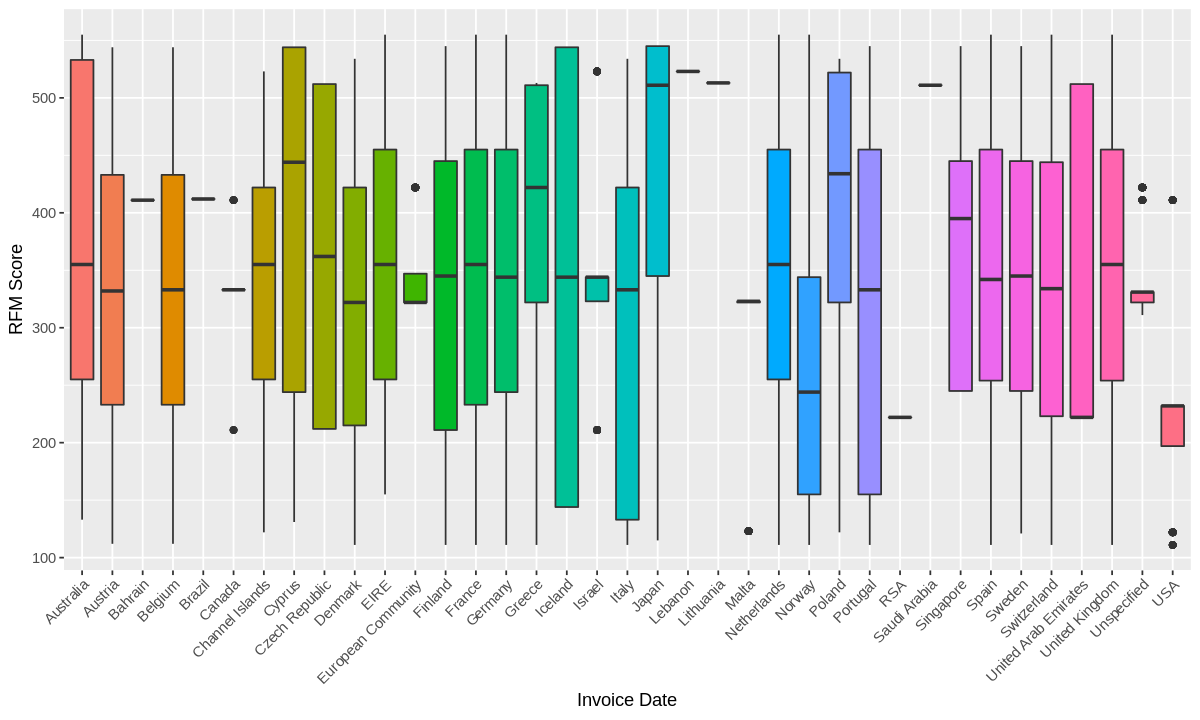

In [77]:
# Plot distribution of purchases per country
ggplot(purchases, aes(x = Country, y = Score, fill = Country)) + 
    geom_boxplot(show.legend = F) +
    xlab("Invoice Date") +
    ylab("RFM Score") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))   

As an illustration of what could be done with the RFM scores, we'll have a look at the characteristics of the top 2% scoring customers compared to the bottom 2%.

In [78]:
top_scorers <- purchases[purchases$Score >= max(purchases$Score) * 0.98, ]
head(top_scorers)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal,Recency,Frequency,FrequencyMonthly,Monetary,MonetaryMonthly,Score
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30,32227200,297,297,5391.21,5391.21,544
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30,32227200,297,297,5391.21,5391.21,544
536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34,32227200,297,297,5391.21,5391.21,544
536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34,32227200,297,297,5391.21,5391.21,544
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00,32227200,297,297,5391.21,5391.21,544
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00,32227200,297,297,5391.21,5391.21,544


In [79]:
bottom_scorers <- purchases[purchases$Score <= min(purchases$Score) * 1.01, ]
head(bottom_scorers)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal,Recency,Frequency,FrequencyMonthly,Monetary,MonetaryMonthly,Score
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
536392,22150,3 STRIPEY MICE FELTCRAFT,6,2010-12-01,1.95,13705,United Kingdom,11.7,32227200,28,10,711.86,318.14,112
536392,22619,SET OF 6 SOLDIER SKITTLES,4,2010-12-01,3.75,13705,United Kingdom,15.0,32227200,28,10,711.86,318.14,112
536392,21891,TRADITIONAL WOODEN SKIPPING ROPE,12,2010-12-01,1.25,13705,United Kingdom,15.0,32227200,28,10,711.86,318.14,112
536392,21889,WOODEN BOX OF DOMINOES,12,2010-12-01,1.25,13705,United Kingdom,15.0,32227200,28,10,711.86,318.14,112
536392,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,2010-12-01,165.00,13705,United Kingdom,165.0,32227200,28,10,711.86,318.14,112
536392,22127,PARTY CONES CARNIVAL ASSORTED,12,2010-12-01,1.25,13705,United Kingdom,15.0,32227200,28,10,711.86,318.14,112


In [0]:
extremes <- rbind(top_scorers, bottom_scorers)

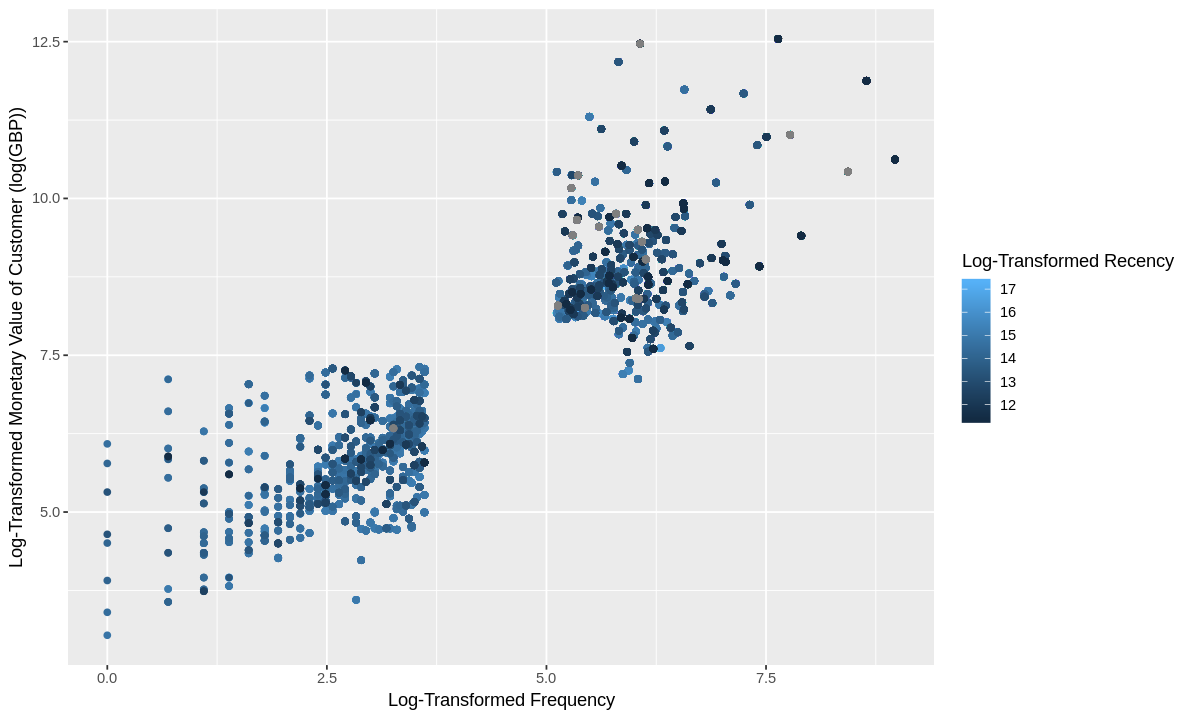

In [81]:
ggplot(extremes, aes(x = log(Frequency), y = log(Monetary))) +
    geom_point(aes(colour = log(Recency))) +
    scale_colour_gradient(name="Log-Transformed Recency") +
    xlab("Log-Transformed Frequency") +
    ylab("Log-Transformed Monetary Value of Customer (log(GBP))")

We can clearly see the top and bottom portions of the data here.  Given more time, there is more we could do to visualise and inspect the RFM score.  For now we will move on to clustering the customers.

## K-Means Clustering

First we need to encode non-numeric features so that we can compute their means.

In [0]:
label_encode <- function(col) {
    if (!is.numeric(col)) {
        as.integer(as.factor(col))
    } else {
        col
    }
}

In [83]:
purchases <- as_tibble(sapply(purchases, label_encode))
head(purchases)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal,Recency,Frequency,FrequencyMonthly,Monetary,MonetaryMonthly,Score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3234,3688,6,1,2.55,17850,35,15.30,32227200,297,297,5391.21,5391.21,544
1,3234,3688,6,1,2.55,17850,35,15.30,32227200,297,297,5391.21,5391.21,544
1,2644,3696,6,1,3.39,17850,35,20.34,32227200,297,297,5391.21,5391.21,544
1,2644,3696,6,1,3.39,17850,35,20.34,32227200,297,297,5391.21,5391.21,544
1,2848,847,8,1,2.75,17850,35,22.00,32227200,297,297,5391.21,5391.21,544
1,2848,847,8,1,2.75,17850,35,22.00,32227200,297,297,5391.21,5391.21,544


Due to time constraints we'll cluster into three and five categories.  Ideally we would try multiple numbers of categories and use an elbow plot to see at which point the reduced variance begins to drop off with increasing categories.

Next we need to scale the features so that K-means is not dominated by ones with larger ranges.

In [84]:
scaled_purchases <- as_tibble(scale(purchases))

# Confirm mean of 0
colMeans(scaled_purchases)

InvoiceNo        StockCode      Description         Quantity 
    1.994788e-15    -2.569688e-17     1.076239e-16    -8.299252e-17 
     InvoiceDate        UnitPrice       CustomerID          Country 
   -1.370054e-15     3.956184e-16     1.266253e-16     9.497250e-16 
    InvoiceTotal          Recency        Frequency FrequencyMonthly 
    2.865299e-16    -1.121872e-15    -3.172099e-17     1.103752e-15 
        Monetary  MonetaryMonthly            Score 
    9.894745e-16    -2.692815e-15     2.098594e-16

In [85]:
# Confirm sd of 1
apply(scaled_purchases, 2, sd)

InvoiceNo        StockCode      Description         Quantity 
               1                1                1                1 
     InvoiceDate        UnitPrice       CustomerID          Country 
               1                1                1                1 
    InvoiceTotal          Recency        Frequency FrequencyMonthly 
               1                1                1                1 
        Monetary  MonetaryMonthly            Score 
               1                1                1

In [0]:
scaled_purchases <- scaled_purchases[, !(names(scaled_purchases) %in% c("Cluster",
                                                                        "Description",
                                                                        "StockCode",
                                                                        "FrequencyMonthly",
                                                                        "MonetaryMonthly"))]

In [0]:
customer_cluster <- kmeans(scaled_purchases, 3, nstart = 20)

In [0]:
scaled_purchases$Cluster <- as.factor(customer_cluster$cluster)

In [89]:
head(scaled_purchases)

InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal,Recency,Frequency,Monetary,Score,Cluster
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.803496,-0.11440991,-1.905663,-0.023348281,1.428732,0.4684829,-0.07077324,1.965957,-0.8988206,-0.676758,1.353757,1
-1.803496,-0.11440991,-1.905663,-0.023348281,1.428732,0.4684829,-0.07077324,1.965957,-0.8988206,-0.676758,1.353757,1
-1.803496,-0.11440991,-1.905663,0.008136849,1.428732,0.4684829,-0.03349002,1.965957,-0.8988206,-0.676758,1.353757,1
-1.803496,-0.11440991,-1.905663,0.008136849,1.428732,0.4684829,-0.03349002,1.965957,-0.8988206,-0.676758,1.353757,1
-1.803496,-0.08695389,-1.905663,-0.015851821,1.428732,0.4684829,-0.02121022,1.965957,-0.8988206,-0.676758,1.353757,1
-1.803496,-0.08695389,-1.905663,-0.015851821,1.428732,0.4684829,-0.02121022,1.965957,-0.8988206,-0.676758,1.353757,1


## Results

Firstly, let's have a look at the size of the groups.

In [90]:
customer_cluster$size

[1] 2256051 2797068  943449

And look at the centres for each variable.

In [91]:
customer_cluster$centers

InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal,Recency,Frequency,Monetary,Score
-0.9939824,-0.02517789,-1.0104786,-0.00838304,-0.02818579,0.3692342,-0.03097389,1.0078615,-0.31472939,-0.4130975,0.14620863
0.7600472,-0.05140898,0.7675183,-0.01576628,0.11017754,0.3957735,-0.05344120,-0.7650745,0.01822213,-0.3500313,-0.10412627
0.1235587,0.21262094,0.1408560,0.06678890,-0.25924614,-2.0563025,0.23250580,-0.1418428,0.69858256,2.0255787,-0.04091994


In [0]:
# Save the total number of samples to use below
n_samples = dim(purchases)[1]

In [93]:
min(scaled_purchases$Score)

[1] -1.724589

In [94]:
max(scaled_purchases$Score)

[1] 1.43196

In [95]:
three_cluster_summary <- scaled_purchases %>%
    group_by(Cluster) %>%
    summarise(ClusterSize = n(),
              ClusterProportion = ClusterSize / n_samples,
              MeanClusterScore = mean(Score),
              MinClusterScore = min(Score),
              MaxClusterScore = max(Score),
              SDClusterScore = sd(Score))
three_cluster_summary

Cluster,ClusterSize,ClusterProportion,MeanClusterScore,MinClusterScore,MaxClusterScore,SDClusterScore
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2256051,0.3762237,0.14620863,-1.724589,1.43196,0.9873459
2,2797068,0.4664448,-0.10412627,-1.724589,1.43196,1.0078862
3,943449,0.1573315,-0.04091994,-1.717480,1.43196,0.9634601


This is not very convincing clustering.  The different sized clusters could be due to a distinct group or outliers and should be investigated further.  For many features, Clusters 1 and 3 have relatively close centre values (e.g. for *CustomerID*, *Quantity* and *UnitPrice*. The cluster scores range from -1.72 to 1.42, the mean scores for clusters 1 and 3 are very close to each other and the ranges of all groups cover the score range almost entirely. so there is a very large overlap in the scores for the clusters.  The standard deviation of the clusters is relatively large compared to the range of the standardised score.  Eyeballing the means and standard deviations, it seems unlikely that these means are significantly different.  An ANOVA may be an appropriate test here given an H0 that the means are equal and HA that they are not.  Further investigation into the distribution of each group for each feature is required.

Let's visualise the results to see if we can understand the clustering better.

In [0]:
colour_palette <- c("#d52685", "#553a99", "#6cbc35", "#fd9f3e", "#08538c")

In [0]:
# To speed up the plot time we'll take a random sample of the data to plot
plot_data <- sample_n(scaled_purchases, 250000)

Warning message in log(Frequency + 1):
“NaNs produced”Warning message in log(Frequency + 1):
“NaNs produced”Warning message:
“Removed 222 rows containing missing values (geom_point).”

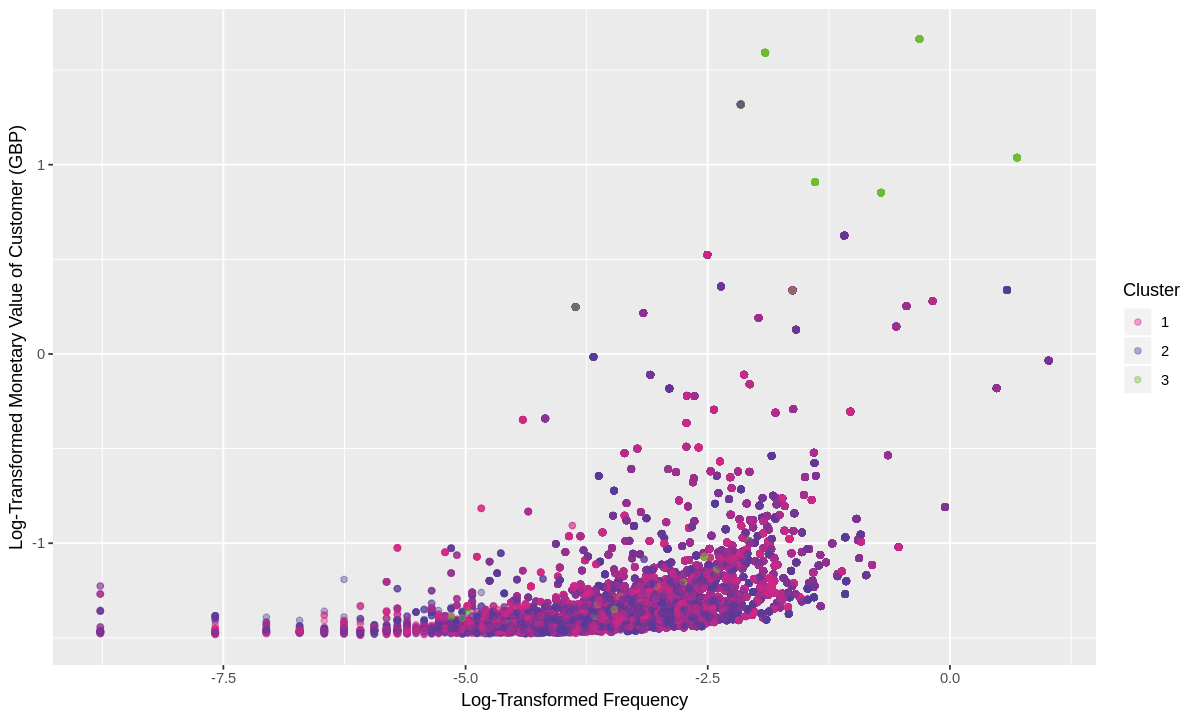

In [98]:
# Plot logs of *Frequency* and *Monetary*, each with +1 to reduce the number of 
# NaNs produced by trying to take the log of a negative number.
ggplot(plot_data, aes(x = log(Frequency + 1), y = log(Monetary + 1), colour = Cluster)) +
    geom_point(alpha = 0.4) +
    scale_color_manual(values = colour_palette) +
    xlab("Log-Transformed Frequency") +
    ylab("Log-Transformed Monetary Value of Customer (GBP)")

It is not obvious via visual inspection that the clusters are meaningfully grouped in monetary-frequency space.

Warning message in log(Frequency + 1):
“NaNs produced”Warning message in log(Frequency + 1):
“NaNs produced”Warning message:
“Removed 222 rows containing missing values (geom_point).”

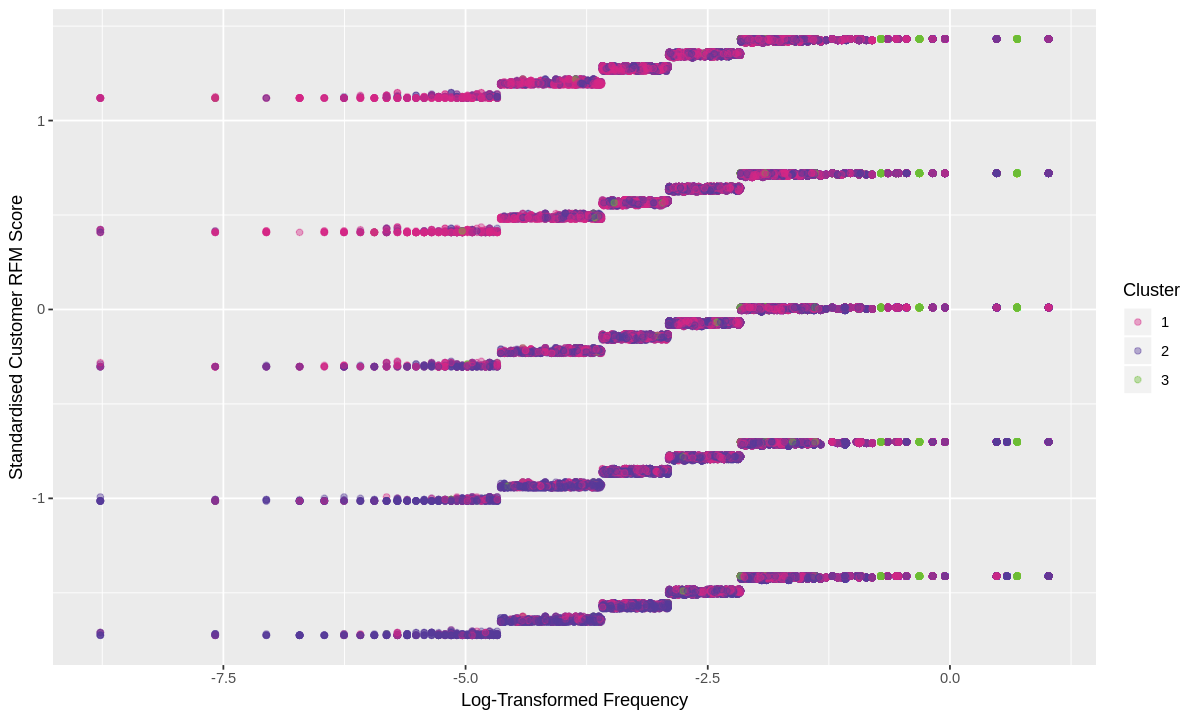

In [99]:
ggplot(plot_data, aes(x = log(Frequency + 1), y = Score, colour = Cluster)) +
    geom_point(alpha = 0.4) +
    scale_color_manual(values = colour_palette) +
    xlab("Log-Transformed Frequency") +
    ylab("Standardised Customer RFM Score")

There is a slightly more discernible pattern to the clustering with regard to RFM score and frequency.  In particular, Cluster 1 tends to appear at lower RFM scores and lower frequencies, with Cluster 2 tending to appear at higher scores and frequencies.

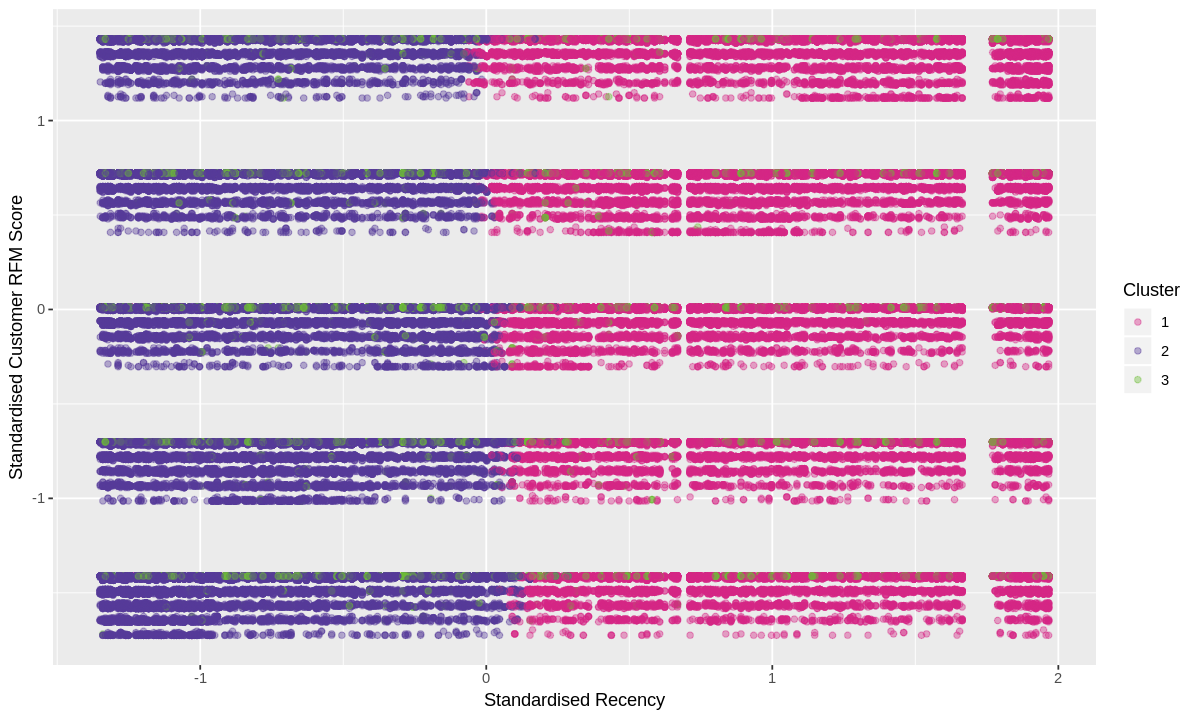

In [100]:
ggplot(plot_data, aes(x = Recency, y = Score, colour = Cluster)) +
    geom_point(alpha = 0.4) +
    scale_color_manual(values = colour_palette) +
    xlab("Standardised Recency") +
    ylab("Standardised Customer RFM Score")

Here we can clearly see the clustering in effect, with frequency being grouped into Clusters 2 and 3.  Cluster 1 appears to be a function of the RFM score.

Next we'll look at five clusters.

In [0]:
scaled_purchases <- scaled_purchases[, !(names(scaled_purchases) %in% c("Cluster",
                                                                        "Description",
                                                                        "StockCode",
                                                                        "FrequencyMonthly",
                                                                        "MonetaryMonthly"))]

In [102]:
customer_cluster <- kmeans(scaled_purchases, 5, nstart = 20)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 299828400)”

Note on some runs a warning message regarding Quick-TRANSfer convergence is given.  For now this has been ignored but a higher *nstart* value or the use of the Lloyd or MacQueen algorithms could be investigated to resolve this.

Looking again at size and centres.

In [103]:
customer_cluster$size

[1] 1345688  935102 1064763  810758 1840257

In [104]:
customer_cluster$centers

InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceTotal,Recency,Frequency,Monetary,Score
0.8343731,-0.04611046,0.8243429,-0.009539459,-0.9650350,0.2829856,-0.04955375,-0.8200636,-0.2361297,-0.34053626,-0.12611004
0.1204886,0.20769939,0.1373177,0.066385222,-0.2511869,-2.0515866,0.22563926,-0.1382788,0.7131727,2.04782646,-0.03910252
0.5035483,0.02024235,0.5393870,-0.016032426,0.7005882,0.4655631,0.01204298,-0.5440053,-0.8271591,-0.58597644,-0.13630243
0.3335622,-0.15690177,0.3531136,-0.027044652,1.4237000,0.4684829,-0.14707614,-0.3571616,1.7680743,-0.03438262,0.03860686
-1.1096672,-0.01440764,-1.1402339,-0.005565754,-0.1992739,0.3597822,-0.02059039,1.1420486,-0.4900861,-0.43736774,0.17394233


In [0]:
scaled_purchases$Cluster <- as.factor(customer_cluster$cluster)

In [106]:
five_cluster_summary <- scaled_purchases %>%
    group_by(Cluster) %>%
    summarise(ClusterSize = n(),
              ClusterProportion = ClusterSize / n_samples,
              MeanClusterScore = mean(Score),
              MinClusterScore = min(Score),
              MaxClusterScore = max(Score),
              SDClusterScore = sd(Score))
five_cluster_summary

Cluster,ClusterSize,ClusterProportion,MeanClusterScore,MinClusterScore,MaxClusterScore,SDClusterScore
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1345688,0.2244097,-0.12611004,-1.724589,1.43196,1.0158243
2,935102,0.1559395,-0.03910252,-1.717480,1.43196,0.9636398
3,1064763,0.1775621,-0.13630243,-1.724589,1.43196,1.0084243
4,810758,0.1352037,0.03860686,-1.411778,1.43196,0.9655015
5,1840257,0.3068850,0.17394233,-1.724589,1.43196,0.9894298


The five cluster results tell a similar story to those for three clusters.

In [0]:
# To speed up the plot time we'll take a random sample of the data to plot
plot_data <- sample_n(scaled_purchases, 250000)

Warning message in log(Frequency + 1):
“NaNs produced”Warning message in log(Frequency + 1):
“NaNs produced”Warning message:
“Removed 223 rows containing missing values (geom_point).”

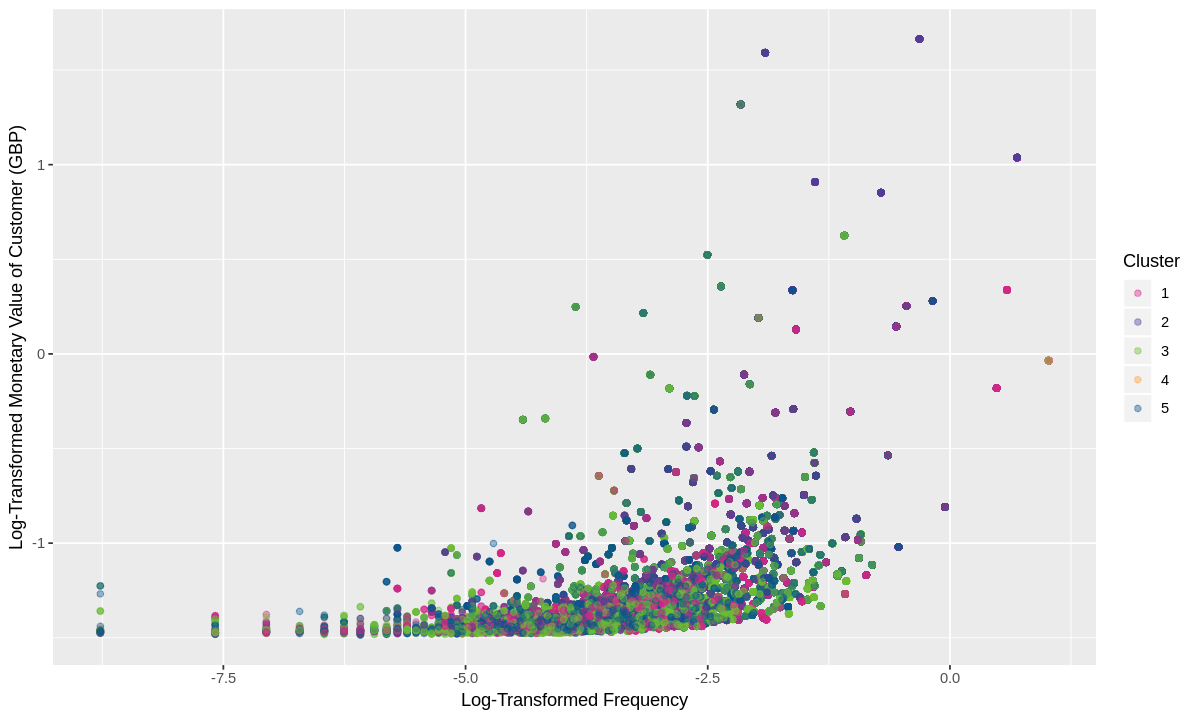

In [108]:
ggplot(plot_data, aes(x = log(Frequency + 1), y = log(Monetary + 1), colour = Cluster)) +
    geom_point(alpha = 0.4) +
    scale_color_manual(values = colour_palette) +
    xlab("Log-Transformed Frequency") +
    ylab("Log-Transformed Monetary Value of Customer (GBP)")

As with three clusters, it is hard to discern a pattern in the groups in frequency-monetary space.

Warning message in log(Frequency + 1):
“NaNs produced”Warning message in log(Frequency + 1):
“NaNs produced”Warning message:
“Removed 223 rows containing missing values (geom_point).”

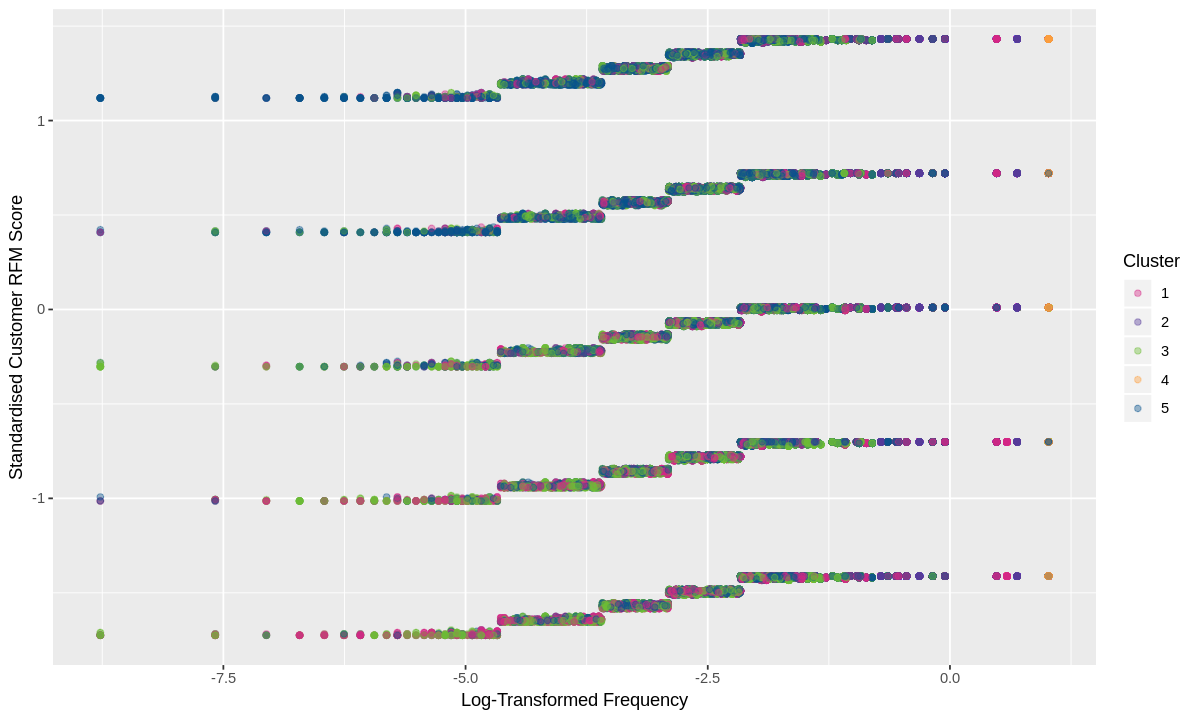

In [109]:
ggplot(plot_data, aes(x = log(Frequency + 1), y = Score, colour = Cluster)) +
    geom_point(alpha = 0.4) +
    scale_color_manual(values = colour_palette) +
    xlab("Log-Transformed Frequency") +
    ylab("Standardised Customer RFM Score")

There seems to be discernible pattern in frequency-RFM score space with clusters grouped in frequency space.

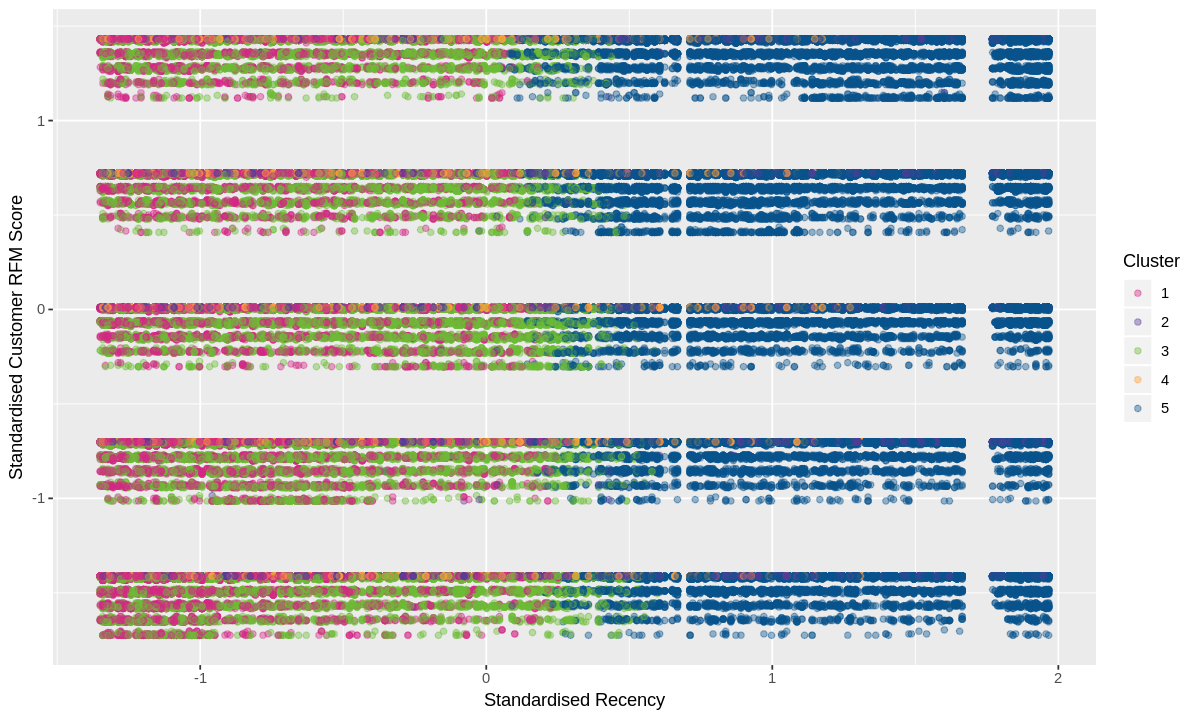

In [110]:
ggplot(plot_data, aes(x = Recency, y = Score, colour = Cluster)) +
    geom_point(alpha = 0.4) +
    scale_color_manual(values = colour_palette) +
    xlab("Standardised Recency") +
    ylab("Standardised Customer RFM Score")

Clusters 3, 4 and 5 are clearly grouped in recency space.  The remaining groups may vary with RFM Score, but this is hard to detect visually.

Let's take a look at how the features correlate with RFM Score and Cluster.

In [0]:
scaled_purchases$Cluster <- as.numeric(scaled_purchases$Cluster)

In [112]:
# Use Spearman's rho instead of Pearson's R as the required
# assumptions (linear relationship in particular) are violated.
purchases %>%
    correlate(method = "spearman") %>%
    focus(Score) %>%
    arrange(desc(Score))


Correlation method: 'spearman'
Missing treated using: 'pairwise.complete.obs'



rowname,Score
<chr>,<dbl>
Monetary,0.1350062320
Frequency,0.1278105217
Recency,0.0910810887
MonetaryMonthly,0.0860263389
FrequencyMonthly,0.0731958058
CustomerID,0.0134043025
Description,-0.0004588225
UnitPrice,-0.0044431665
Country,-0.0081123225


Unsurprisingly, Score is most correlated with the components from which it was generated.  The correlation of Score with other features is very low.

In [0]:
scaled_purchases %>% 
    correlate(method = "spearman") %>%
    focus(Cluster) %>%
    arrange(desc(Cluster))

In [0]:
pca <- prcomp(customer_cluster$centers,
       center = T,
       scale. = T,
       rank. = 2)

In [0]:
pca

In [0]:
plot(pca, type = 'l')

## Conclusions

A preliminary investigation into the use of RFM and K-means clustering for customer segmentation has been performed.  Due to time constraints, limited optimisation of the algorithms and exploration of the results have been possible.  However, the basic approach has been demonstrated and the work could form the basis of further analysis.

Further activites could include:
1. Investigation into the method of data collection and missing data, such as the lack of data for Saturdays and the missing customer IDs.
2. Investigation into the use of RFM.  For example, using other features (such as the monthly ones generated above), different binning, weighting of the RFM scores and different overall scoring methods.
3. Optimisation of K-means clustering.  As stated above, trying different numbers of clusters and selecting via explained variance (e.g. an elbow plot) would be an improvement.
4. Assess the features used in the model, including whether segmentation can be improved by removing *Description* and *StockCode*, which are features that are more likely to be useful following RFM analysis (e.g. identifying products that may benefit the most from an advertising campaign).
5. Explore the use of PCA for feature extraction and to visualise the results – groups may be more apparent if the data is decomposed to two dimensions, rather than trying to identify them in multiple plots.
6. Explore the use of random forests for customer segmentation.
7. Explore the results of the segmentation further.  For example, use of some more interesting plots (e.g. heatplots to visualise correlations, a map to show customer scores geographically, an area chart to show scores for different segments, etc.) and further investigation into the distribution of each group for each feature would be useful.
8. Once a satisfactory segmentation has been obtained via analysis, either verify the model against previous segmentation data or validate it with tests (e.g. test campaigns and customer surveys).